# Analysis of spontaneous activity 
------
Neurons in the primary visual cortex may be active also in absence of visual stimulation. Spontaneous activity is crucial during cortical development, but is also present in adulthood.

#### Import packages

In [2]:
from allensdk.core.brain_observatory_cache import BrainObservatoryCache
from allensdk.core.brain_observatory_nwb_data_set import BrainObservatoryNwbDataSet
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import json
import math
import os
# import scipy
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from scipy.stats import zscore, spearmanr, pearsonr
from tqdm import tqdm


#### define helper functions

In [3]:
def find_nearest(array,value):
    idx = np.searchsorted(array, value, side="left")
    if idx > 0 and (idx == len(array) or math.fabs(value - array[idx-1]) < math.fabs(value - array[idx])):
        return array[idx-1]
    else:
        return array[idx]

def nan_helper(y):
    """Helper to handle indices and logical indices of NaNs.

    Input:
        - y, 1d numpy array with possible NaNs
    Output:
        - nans, logical indices of NaNs
        - index, a function, with signature indices= index(logical_indices),
          to convert logical indices of NaNs to 'equivalent' indices
    Example:
        >>> # linear interpolation of NaNs
        >>> nans, x= nan_helper(y)
        >>> y[nans]= np.interp(x(nans), x(~nans), y[~nans])
    """

    return np.isnan(y), lambda z: z.nonzero()[0]

### Download the data

#### Neurophysiology data: Slc17a7-IRES2-Cre driver line
Exploring recordings from a mouse line expressing GCamP6 in excitatory neurons (recordings in VISp)

In [4]:
filter_json = """
[
    {
        "field": "area",
        "op": "in",
        "value": [
            "VISp"
        ]
    },
    {
        "field": "tld1_name",
        "op": "in",
        "value": [
            "Slc17a7-IRES2-Cre"
        ]
    }
]
"""
       
filters = json.loads(filter_json)
boc = BrainObservatoryCache(manifest_file="brain_observatory/manifest.json")
cells = boc.get_cell_specimens(filters=filters)
cells_df = pd.DataFrame(cells)
cells_df

,all_stim,area,cell_specimen_id,donor_full_genotype,dsi_dg,experiment_container_id,failed_experiment_container,g_dsi_dg,g_osi_dg,g_osi_sg,...,specimen_id,tfdi_dg,time_to_peak_ns,time_to_peak_sg,tld1_id,tld1_name,tld2_id,tld2_name,tlr1_id,tlr1_name
0,False,VISp,662221759,Slc17a7-IRES2-Cre/wt;Camk2a-tTA/wt;Ai93(TITL-G...,NaN,647155120,False,NaN,NaN,NaN,...,617884009,NaN,NaN,NaN,180526080,Slc17a7-IRES2-Cre,177837320,Camk2a-tTA,265943423,Ai93(TITL-GCaMP6f)
1,False,VISp,662221806,Slc17a7-IRES2-Cre/wt;Camk2a-tTA/wt;Ai93(TITL-G...,0.783525,647155120,False,0.708307,0.351490,1.000000,...,617884009,0.333157,0.22603,0.29061,180526080,Slc17a7-IRES2-Cre,177837320,Camk2a-tTA,265943423,Ai93(TITL-GCaMP6f)
2,False,VISp,662221843,Slc17a7-IRES2-Cre/wt;Camk2a-tTA/wt;Ai93(TITL-G...,NaN,647155120,False,0.213650,0.301664,NaN,...,617884009,0.265027,NaN,NaN,180526080,Slc17a7-IRES2-Cre,177837320,Camk2a-tTA,265943423,Ai93(TITL-GCaMP6f)
3,False,VISp,662221883,Slc17a7-IRES2-Cre/wt;Camk2a-tTA/wt;Ai93(TITL-G...,0.402791,647155120,False,0.227151,0.459935,0.341240,...,617884009,0.196362,0.29061,0.19374,180526080,Slc17a7-IRES2-Cre,177837320,Camk2a-tTA,265943423,Ai93(TITL-GCaMP6f)
4,False,VISp,662221929,Slc17a7-IRES2-Cre/wt;Camk2a-tTA/wt;Ai93(TITL-G...,NaN,647155120,False,NaN,NaN,NaN,...,617884009,NaN,NaN,NaN,180526080,Slc17a7-IRES2-Cre,177837320,Camk2a-tTA,265943423,Ai93(TITL-GCaMP6f)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6254,True,VISp,701733780,Slc17a7-IRES2-Cre/wt;Camk2a-tTA/wt;Ai94(TITL-G...,1.334474,688678764,False,0.249647,0.134671,0.598213,...,659422762,0.310344,0.36487,0.39804,180526080,Slc17a7-IRES2-Cre,177837320,Camk2a-tTA,310469713,Ai94(TITL-GCaMP6s)
6255,False,VISp,701733789,Slc17a7-IRES2-Cre/wt;Camk2a-tTA/wt;Ai94(TITL-G...,NaN,688678764,False,NaN,NaN,NaN,...,659422762,NaN,NaN,NaN,180526080,Slc17a7-IRES2-Cre,177837320,Camk2a-tTA,310469713,Ai94(TITL-GCaMP6s)
6256,False,VISp,701733802,Slc17a7-IRES2-Cre/wt;Camk2a-tTA/wt;Ai94(TITL-G...,0.483729,688678764,False,0.443473,0.477331,NaN,...,659422762,0.375640,NaN,NaN,180526080,Slc17a7-IRES2-Cre,177837320,Camk2a-tTA,310469713,Ai94(TITL-GCaMP6s)
6257,False,VISp,701733837,Slc17a7-IRES2-Cre/wt;Camk2a-tTA/wt;Ai94(TITL-G...,0.065206,688678764,False,0.101129,0.729779,NaN,...,659422762,0.366087,NaN,NaN,180526080,Slc17a7-IRES2-Cre,177837320,Camk2a-tTA,310469713,Ai94(TITL-GCaMP6s)


In [5]:
cells_df.columns.unique().tolist()
cont_ids = cells_df['experiment_container_id'].unique()
experiments = boc.get_ophys_experiments(experiment_container_ids=cont_ids, include_failed=False, require_eye_tracking=True)
exp_ids = [d['id'] for d in experiments]
exp_ids = exp_ids[:20]

In [ ]:
saving_dir = r'D:\BrainObservatory\brain_observatory\ophys_experiment_data'
files = os.listdir(saving_dir)
exp_ids = [int(s[:-4]) for s in files]
exp_ids

In [9]:
bad_ids = []
for exp in tqdm(exp_ids):
    try:
        boc.get_ophys_pupil_data(exp,  suppress_pupil_data=False)
        boc.get_ophys_experiment_data(exp)
    except Exception:
        bad_ids.append(exp)
        print('a')
# exp_ids = [id for id in exp_ids if id not in bad_ids]

for exp in tqdm(exp_ids):
    boc.get_ophys_experiment_data(exp)


100%|██████████| 20/20 [00:00<00:00, 107.04it/s]


In [10]:
n =0


id = exp_ids[n]
exp  = boc.get_ophys_experiment_data(id)
dff = exp.get_dff_traces()
calcium = zscore(dff[1], axis = 1, ddof=1)
eye = boc.get_ophys_pupil_data(id, suppress_pupil_data=False)
stim = boc.get_ophys_experiment_stimuli(id)



In [11]:
spont = exp.get_stimulus_table('spontaneous').values
spont

array([[30534, 39681],
       [89097, 98242]])

In [12]:
ts_blocks = []
for i in range(spont.shape[1]):
    ts_blocks.append(dff[0][spont[i,0]:spont[i,1]])
ts = np.hstack(ts_blocks)


In [13]:
eye_ts_blocks =[]
eye_sp_blocks = []
for t in ts_blocks:
    eye_ts_blocks = [find_nearest(eye.index.tolist(), t[0]), find_nearest(eye.index.tolist(), t[-1])]
    eye_sp_blocks.append(eye.loc[eye_ts_blocks[0]:eye_ts_blocks[1]])
eye_sp = pd.concat(eye_sp_blocks, axis = 0)
eye_sp

,raw_eye_area,raw_pupil_area,raw_screen_coordinates_x_cm,raw_screen_coordinates_y_cm,raw_screen_coordinates_spherical_x_deg,raw_screen_coordinates_spherical_y_deg,filtered_eye_area,filtered_pupil_area,filtered_screen_coordinates_x_cm,filtered_screen_coordinates_y_cm,filtered_screen_coordinates_spherical_x_deg,filtered_screen_coordinates_spherical_y_deg
989.26967,16331.800677,251.911015,15.070279,29.360308,5.631626,11.076004,16331.800677,251.911015,15.070279,29.360308,5.631626,11.076004
989.30181,16219.501606,256.614149,15.043848,29.197786,5.622950,11.016198,16219.501606,256.614149,15.043848,29.197786,5.622950,11.016198
989.33655,16170.214759,260.404304,15.042225,29.368809,5.621150,11.079132,16170.214759,260.404304,15.042225,29.368809,5.621150,11.079132
989.36967,16264.529615,249.228901,15.613098,28.964110,5.835965,10.930164,16264.529615,249.228901,15.613098,28.964110,5.835965,10.930164
989.40265,16431.051611,259.019528,15.212853,28.689462,5.689271,10.828983,16431.051611,259.019528,15.212853,28.689462,5.689271,10.828983
...,...,...,...,...,...,...,...,...,...,...,...,...
3176.20668,16749.213041,246.726977,16.856393,29.252076,6.294852,11.036179,16749.213041,246.726977,16.856393,29.252076,6.294852,11.036179
3176.23996,16727.729802,236.073256,16.642059,29.647997,6.212365,11.181811,16727.729802,236.073256,16.642059,29.647997,6.212365,11.181811
3176.27325,16689.505431,231.333616,16.992390,29.663493,6.341962,11.187508,16689.505431,231.333616,16.992390,29.663493,6.341962,11.187508
3176.30660,16739.976418,235.938106,16.884402,28.999684,6.307197,10.943265,16739.976418,235.938106,16.884402,28.999684,6.307197,10.943265


In [ ]:
pupil = []
pupilraw = []
for eye_df, t in zip(eye_sp_blocks, ts_blocks):
    new_pupil = np.interp(t, eye_df.index.to_list(),  eye_df['filtered_pupil_area'])
    nans, x= nan_helper(new_pupil)
    new_pupil[nans]= np.interp(x(nans), x(~nans), new_pupil[~nans])
    new_pupil_1 = new_pupil.copy()
    new_pupil = pd.Series(new_pupil).rolling(60, min_periods=1).median().values

    new_pupil = zscore(new_pupil, ddof=1, nan_policy = 'omit')
    new_pupil_1 = zscore(new_pupil_1, ddof=1, nan_policy = 'omit')

    pupil.append(new_pupil)
    pupilraw.append(new_pupil_1)

pupil = np.hstack(pupil)
pupilraw = np.hstack(pupilraw)



In [ ]:
%matplotlib inline
plt.figure(figsize= (22,4))
plt.plot(pupilraw)
plt.plot(pupil)

# 
# plt.plot(eye_sp.index.tolist(), eye_sp['raw_pupil_area'])

In [ ]:
traces =[]
for i in range(spont.shape[1]):
    traces.append(calcium[:,spont[i,0] : spont[i,-1]])
traces = np.hstack(traces)


In [ ]:
pca = PCA()

components = pca.fit_transform(traces.T)
scree1 = np.cumsum(pca.explained_variance_ratio_)

pca.explained_variance_ratio_



In [ ]:
sns.set_context('talk')
f, ax = plt.subplots()

sns.lineplot(scree1)


ax.set_title('Dimensionality of spontaneous activity')
ax.set_ylabel('Cumulative fraction\nof variance explained')
ax.set_xlabel('Number of components')

In [ ]:
dff_0 = traces[:,:-500].T
dff_1 = traces[:,-501:].T
eye_0 = pupil[:-500]
eye_1 = pupil[-501:]
train_dff, test_dff, train_pupil, test_pupil = train_test_split(dff_0, eye_0, random_state=42)

In [ ]:
# dff_0 = traces[:,:-500].T
# dff_1 = traces[:,-501:].T
# eye_0 = pupil[:-500]
# eye_1 = pupil[-501:]
# poly = PolynomialFeatures(degree=3, include_bias=False)
# poly_features = poly.fit_transform(dff_0)
# train_dff, test_dff, train_pupil, test_pupil = train_test_split(poly_features, eye_0, random_state=42)

In [ ]:
lr = LinearRegression()

lr.fit(train_dff, train_pupil)

In [ ]:
pupil_pred = lr.predict(dff_1)

mean_squared_error(eye_0,pupil_pred)

In [ ]:
r2_score(eye_1,pupil_pred)

In [ ]:
plt.subplots(figsize = (12,6))
plt.plot(eye_0)
plt.plot(pupil_pred, alpha = .4)

In [ ]:
r = Ridge(alpha=10, random_state = 42)

r.fit(train_dff, train_pupil)
pupil_pred = r.predict(dff_1)
print(r.score(test_dff, test_pupil))
plt.plot(eye_1)
plt.plot(pupil_pred)

In [ ]:
l = Lasso(random_state = 42)

l.fit(train_dff, train_pupil)
pupil_pred = l.predict(dff_1)
l.score(test_dff, test_pupil)

In [ ]:
plt.plot(eye_1)
plt.plot(pupil_pred)

In [ ]:
rf = RandomForestRegressor(n_estimators =300, random_state = 42, oob_score = True, n_jobs  =4, verbose = True)

rf.fit(train_dff, train_pupil)
pupil_pred = rf.predict(dff_1)
print(rf.score(test_dff, test_pupil))

plt.subplots(figsize =  (12, 4))
plt.plot(eye_1 ,linewidth = 1, alpha = .99)
plt.plot(pupil_pred, linewidth = 1, alpha = .4)
plt.plot(pd.Series(pupil_pred).rolling(7).median() ,linewidth = 1, alpha = .6, color = 'r')

In [ ]:
pupil_pred = rf.predict(dff_0)
print(rf.score(test_dff, test_pupil))

plt.subplots(figsize =  (12, 4))
plt.plot(eye_0 ,linewidth = 1, alpha = .99)
plt.plot(pupil_pred, linewidth = 1, alpha = .4)
plt.plot(pd.Series(pupil_pred).rolling(7).median() ,linewidth = 1, alpha = .6, color = 'r')

In [ ]:
r, p = spearmanr(components[:,0], new_pupil)


r**2

In [ ]:
p>0.05

In [ ]:
eye_xpos = np.interp(ts, eye_sp.index.to_list(),  eye_sp['filtered_screen_coordinates_spherical_x_deg'])
nans, x= nan_helper(eye_xpos)
eye_xpos[nans]= np.interp(x(nans), x(~nans), eye_xpos[~nans])
eye_xpos_1 = eye_xpos.copy()
eye_xpos = pd.Series(eye_xpos).rolling(30, min_periods=1).median().values

eye_xpos = zscore(eye_xpos, ddof=1, nan_policy = 'omit')
eye_xpos_1 = zscore(eye_xpos_1, ddof=1, nan_policy = 'omit')

In [ ]:
%matplotlib inline
plt.figure(figsize= (12,4))
plt.plot(ts, eye_xpos_1)
plt.plot(ts, eye_xpos)

In [ ]:
eyex_0 = eye_xpos_1[:-300]
eyex_1 = eye_xpos_1[-300:]
train_dff, test_dff, train_x, test_x = train_test_split(dff_0, eyex_0, random_state=42)

In [ ]:
r = Ridge(alpha=1, random_state = 42)

r.fit(train_dff, train_x)
x_pred = r.predict(dff_1)
print(r.score(test_dff, test_x))
plt.plot(eyex_1)
plt.plot(x_pred)

In [ ]:
rf = RandomForestRegressor(n_estimators =400, random_state = 42, oob_score = True, n_jobs  =12, verbose = True)

rf.fit(train_dff, train_x)
x_pred = rf.predict(dff_1)
rf.score(test_dff, test_x)

plt.subplots(figsize =  (12, 4))
plt.plot(eyex_1 ,linewidth = 1, alpha = .99)
plt.plot(x_pred, linewidth = 1, alpha = .4)
plt.plot(pd.Series(x_pred).rolling(7).median() ,linewidth = 1, alpha = .6, color = 'r')

In [11]:
speed = exp.get_running_speed()


In [12]:
abs_speed = zscore(np.abs(speed[0][spont[0]:spont[1]]), ddof = 1)
plt.plot(abs_speed)
r, p = spearmanr(components[:,0], abs_speed)


TypeError: only integer scalar arrays can be converted to a scalar index

In [ ]:
speed = speed[spont[0]:spont]

In [ ]:
run_0 = abs_speed[:-300]
run_1 = abs_speed[-300:]
train_dff, test_dff, train_run, test_run = train_test_split(dff_0, run_0, random_state=42)

In [ ]:
r = Ridge(alpha=15, random_state = 42)

r.fit(train_dff, train_run)
run_pred = r.predict(dff_1)
print(r.score(test_dff, test_run))
plt.plot(run_1)
plt.plot(run_pred)

In [ ]:
rf = RandomForestRegressor(n_estimators =400, random_state = 42, oob_score = True, n_jobs  =12, verbose = True)

rf.fit(train_dff, train_run)
run_pred = rf.predict(dff_1)
rf.score(test_dff, test_run)

plt.subplots(figsize =  (12, 4))
plt.plot(run_1 ,linewidth = 1, alpha = .99)
plt.plot(run_pred, linewidth = 1, alpha = .4)
plt.plot(pd.Series(run_pred).rolling(7).median() ,linewidth = 1, alpha = .6, color = 'r')

In [8]:
id

<function id(obj, /)>

In [98]:
dff[1].shape

(181, 127880)

In [17]:
events = boc.get_ophys_experiment_events(id)
events.shape

(181, 127880)

In [18]:
exp.get_stimulus_epoch_table()

,stimulus,start,end
0,locally_sparse_noise_4deg,945,15974
1,locally_sparse_noise_8deg,15975,30384
2,spontaneous,30534,39681
3,natural_movie_one,39682,48976
4,locally_sparse_noise_4deg,49596,64624
5,locally_sparse_noise_8deg,64625,79032
6,natural_movie_two,79653,88947
7,spontaneous,89097,98242
8,locally_sparse_noise_8deg,98243,112680
9,locally_sparse_noise_4deg,112681,127646


In [19]:
events_sp =[]
for i in range(spont.shape[1]):
    events_sp.append(events[:,spont[i,0] : spont[i,-1]])
events_sp = np.hstack(events_sp)


Text(0.5, 0, 'Frequency (events/s)')

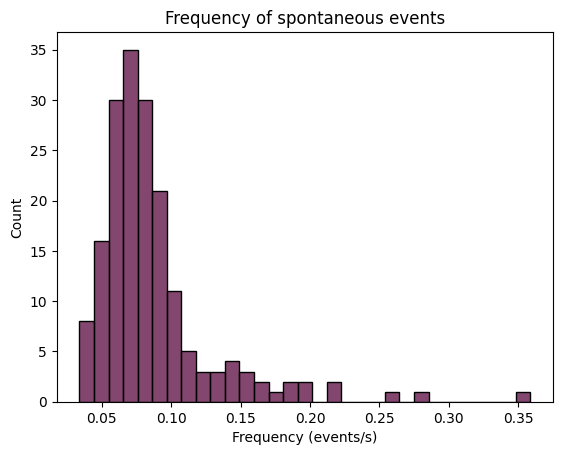

In [20]:
import matplotlib.cm as cm

cmap = cm.get_cmap('twilight')
freq = ((events_sp>0).sum(axis = 1))/((ts_blocks[0][-1]-ts_blocks[0][0])+(ts_blocks[1][-1]-ts_blocks[1][0]))
sns.histplot(freq, color=cmap(0.6), alpha = .8)

plt.title('Frequency of spontaneous events')
plt.xlabel('Frequency (events/s)')

Text(0.5, 0, 'Amplitude ($\\Delta$F/F)')

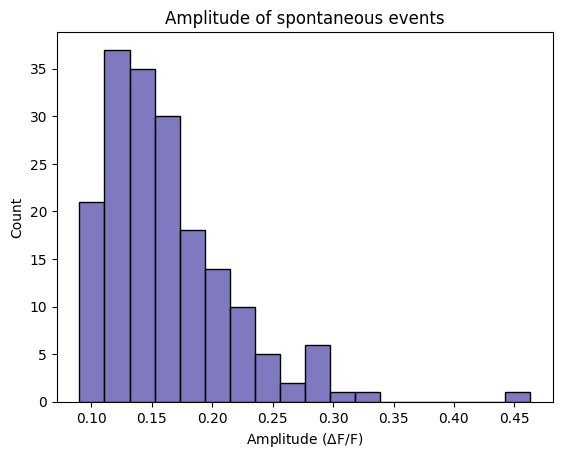

In [29]:

amp = events_sp.sum(axis = 1) /np.count_nonzero(events_sp, axis =1)

sns.histplot(amp, color=cmap(0.3), alpha = .8)

plt.title('Amplitude of spontaneous events')
plt.xlabel('Amplitude ($\Delta$F/F)')

Text(0.5, 0, 'time (ms)')

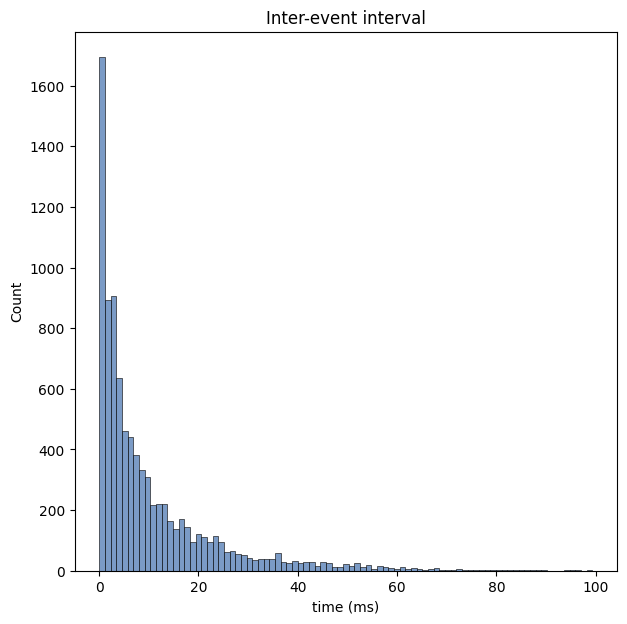

In [126]:
times = []
blocks_idx = np.diff(spont)
for i in range(events_sp.shape[0]):
    tot_bool = events_sp[i,:]>0
    bol1 = np.zeros(tot_bool.shape, dtype = bool)
    bol1[:blocks_idx[0][0]] = tot_bool[:blocks_idx[0][0]]
    bol2 = np.zeros(tot_bool.shape, dtype = bool)
    bol2[blocks_idx[0][0]+1:] = tot_bool[blocks_idx[0][0]+1:]
    times.append(ts[bol1])
    times.append(ts[bol2])
interv = [np.diff(t) for t in times]

interv1 = np.hstack(interv)
f, ax = plt.subplots(figsize=(7, 7))
# ax.set(yscale="log")
# for intv in interv:
#     plt.figure()
sns.histplot(interv1, color=cmap(0.2), alpha = .9)

plt.title('Inter-event interval')
plt.xlabel('time (ms)')


In [120]:
bol2.sum()

36

In [125]:
a = boc.get_ophys_experiment_data(647155122)
a.get_stimulus_epoch_table()
f = a.get_dff_traces()[1][:,908:19468]
e = boc.get_ophys_experiment_events(647155122)[:,908:19468]

In [126]:
# e = boc.get_ophys_experiment_events(647155122)
e

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

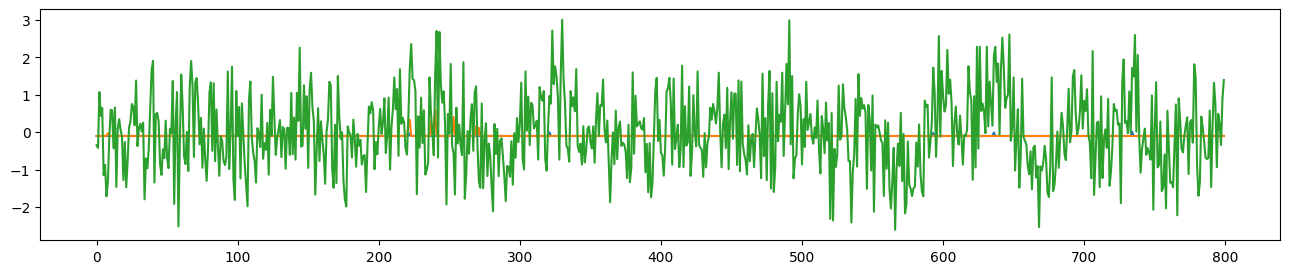

In [129]:
plt.figure(figsize=(16,3))

plt.plot(e[11,1000:1800]-0.1)
plt.plot(e[0,1000:1800]-0.1)
plt.plot(zscore(f[11,1000:1800]))

In [132]:
b = boc.get_ophys_experiment_analysis(647155122, 'drifting_gratings')

In [135]:

boc.get_ophys_experiment_stimuli(exp_ids[2])
exp2 = boc.get_ophys_experiment_data(exp_ids[2])
exp2.get_stimulus_epoch_table()

,stimulus,start,end
0,static_gratings,742,15189
1,natural_scenes,16093,30540
2,spontaneous,30690,39568
3,natural_scenes,39569,54016
4,static_gratings,54919,69366
5,natural_movie_one,70269,79298
6,natural_scenes,80201,96077
7,static_gratings,97357,113608
